In [23]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Function to remove outliers using Z-score
def remove_outliers(df, sensor_columns, z_thresh=3):
    """
    Removes rows with outliers based on Z-scores for specified sensor columns.
    
    Parameters:
    df (DataFrame): The input DataFrame containing sensor data.
    sensor_columns (list): List of sensor columns to check for outliers.
    z_thresh (float): The Z-score threshold to consider as an outlier.
    
    Returns:
    DataFrame: DataFrame with outliers removed.
    """
    # Calculate Z-scores for the sensor data
    z_scores = np.abs(zscore(df[sensor_columns]))
    
    # Keep rows where all Z-scores are below the threshold
    df_clean = df[(z_scores < z_thresh).all(axis=1)]
    
    return df_clean

# Load your datasets
data_23rd = pd.read_csv(r'C:/Users/aidan/codeprojects/ML/ArduinoWineSniffer/src/data_analysis_for_NN/cleaned_data23rd.csv')
data_30th = pd.read_csv(r'C:/Users/aidan/codeprojects/ML/ArduinoWineSniffer/src/data_analysis_for_NN/cleaned_data30th.csv')

# Drop unnecessary timestamp column
data_23rd.drop(columns=['yyyy-mm-dd timestamp'], inplace=True)
data_30th.drop(columns=['yyyy-mm-dd timestamp'], inplace=True)

# Add a 'Day' column to distinguish between datasets
data_23rd['Day'] = '23rd'
data_30th['Day'] = '30th'

# Define sensor columns (you may need to adjust this based on your dataset)
sensor_columns = ["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]

# Remove outliers from each dataset before combining
data_23rd_clean = remove_outliers(data_23rd, sensor_columns)
data_30th_clean = remove_outliers(data_30th, sensor_columns)

# Combine cleaned datasets for processing
combined_data_clean = pd.concat([data_23rd_clean, data_30th_clean], ignore_index=True)

# Filter for specific wine labels in the Target column
wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]
filtered_data_clean = combined_data_clean[combined_data_clean['Target'].str.contains('|'.join(wine_labels))]

# Separate features and target labels
features = filtered_data_clean.drop(columns=['Target', 'Day'])
target_labels = filtered_data_clean['Target']
day_labels = filtered_data_clean['Day']

# Print the cleaned filtered data
print(filtered_data_clean)


          MQ6  MQ5    MQ4  MQ7    MQ3  MQ8  MQ2  MQ135    MQ9  BMPTemperature  \
0       523.0  786  734.0  329  919.0  708  757    730  701.0           33.63   
1       522.0  787  734.0  329  920.0  708  757    729  702.0           33.64   
2       522.0  788  733.0  327  918.0  708  757    729  701.0           33.65   
3       520.0  787  735.0  330  919.0  708  759    730  703.0           33.65   
4       522.0  787  733.0  327  919.0  708  757    729  701.0           33.65   
...       ...  ...    ...  ...    ...  ...  ...    ...    ...             ...   
125653  376.0  761  682.0  269  948.0  579  662    561  697.0           33.12   
125654  378.0  759  684.0  267  950.0  578  661    562  697.0           33.12   
125655  376.0  761  683.0  267  949.0  577  661    563  696.0           33.12   
125656  376.0  761  682.0  269  949.0  578  662    561  697.0           33.12   
125657  376.0  761  682.0  269  950.0  579  660    562  695.0           33.12   

        Pressure(Pa)  DHTTe

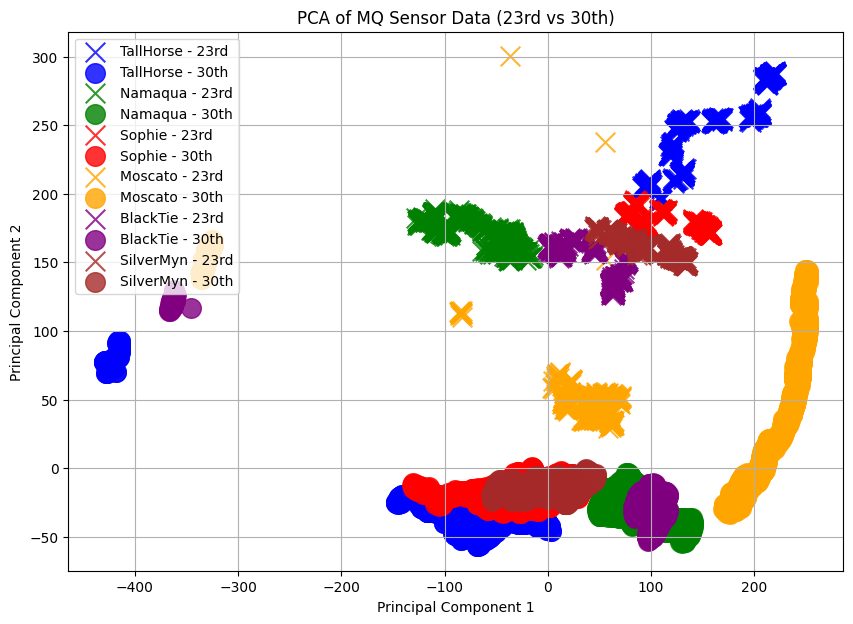

Average distances between 'X's (23rd) and 'O's (30th) for each wine:
TallHorse: 329.82
Namaqua: 224.14
Sophie: 207.16
Moscato: 152.86
BlackTie: 174.50
SilverMyn: 173.88


In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# Separate MQ sensors and target labels
mq_sensors = ["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]
sensor_data = filtered_data[mq_sensors]
target_labels = filtered_data['Target']
day_labels = filtered_data['Day']

# Perform PCA to reduce to two principal components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sensor_data)

# Create a new DataFrame with the PCA results, wine labels, and day labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Target'] = target_labels.values
pca_df['Day'] = day_labels.values

# Define color map for each wine label
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Plot PCA results with improved visibility
plt.figure(figsize=(10, 7))
marker_size = 200  # Define a large marker size

# Store average distances between 23rd and 30th day points for each wine
avg_distances = {}

# Loop through each wine and plot
for wine in wine_labels:
    # Plot 'X' for the 23rd
    wine_data_23rd = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '23rd')]
    plt.scatter(wine_data_23rd['PC1'], wine_data_23rd['PC2'], 
                color=color_map[wine], marker='x', label=f'{wine} - 23rd', 
                s=marker_size, alpha=0.8)
    
    # Plot 'O' for the 30th
    wine_data_30th = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '30th')]
    plt.scatter(wine_data_30th['PC1'], wine_data_30th['PC2'], 
                color=color_map[wine], marker='o', label=f'{wine} - 30th', 
                s=marker_size, alpha=0.8)
    
    # Calculate the average distance between the points from 23rd and 30th
    if len(wine_data_23rd) > 0 and len(wine_data_30th) > 0:
        distances = cdist(wine_data_23rd[['PC1', 'PC2']], wine_data_30th[['PC1', 'PC2']])
        avg_distance = np.mean(np.min(distances, axis=1))  # Take the minimum distance for each point
        avg_distances[wine] = avg_distance

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of MQ Sensor Data (23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()

# Print the average distances between the 23rd and 30th for each wine
print("Average distances between 'X's (23rd) and 'O's (30th) for each wine:")
for wine, distance in avg_distances.items():
    print(f"{wine}: {distance:.2f}")


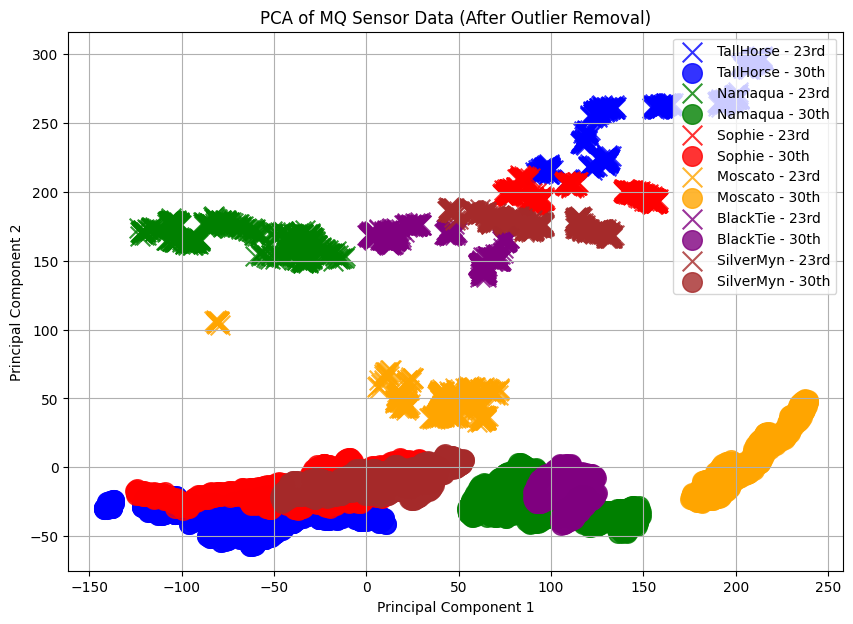

Average distances between 'X's (23rd) and 'O's (30th) for each wine:
TallHorse: 328.82
Namaqua: 218.99
Sophie: 212.26
Moscato: 154.24
BlackTie: 173.97
SilverMyn: 176.81


In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# Separate MQ sensors and target labels
mq_sensors = ["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]
sensor_data = filtered_data_clean[mq_sensors]
target_labels = filtered_data_clean['Target']
day_labels = filtered_data_clean['Day']

# Perform PCA to reduce to two principal components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sensor_data)

# Create a new DataFrame with the PCA results, wine labels, and day labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Target'] = target_labels.values
pca_df['Day'] = day_labels.values

# Define color map for each wine label
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Plot PCA results with improved visibility
plt.figure(figsize=(10, 7))
marker_size = 200  # Define a large marker size

# Store average distances between 23rd and 30th day points for each wine
avg_distances = {}

# Loop through each wine and plot
for wine in wine_labels:
    # Plot 'X' for the 23rd
    wine_data_23rd = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '23rd')]
    plt.scatter(wine_data_23rd['PC1'], wine_data_23rd['PC2'], 
                color=color_map[wine], marker='x', label=f'{wine} - 23rd', 
                s=marker_size, alpha=0.8)
    
    # Plot 'O' for the 30th
    wine_data_30th = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '30th')]
    plt.scatter(wine_data_30th['PC1'], wine_data_30th['PC2'], 
                color=color_map[wine], marker='o', label=f'{wine} - 30th', 
                s=marker_size, alpha=0.8)
    
    # Calculate the average distance between the points from 23rd and 30th
    if len(wine_data_23rd) > 0 and len(wine_data_30th) > 0:
        distances = cdist(wine_data_23rd[['PC1', 'PC2']], wine_data_30th[['PC1', 'PC2']])
        avg_distance = np.mean(np.min(distances, axis=1))  # Take the minimum distance for each point
        avg_distances[wine] = avg_distance

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of MQ Sensor Data (After Outlier Removal)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()

# Print the average distances between the 23rd and 30th for each wine
print("Average distances between 'X's (23rd) and 'O's (30th) for each wine:")
for wine, distance in avg_distances.items():
    print(f"{wine}: {distance:.2f}")


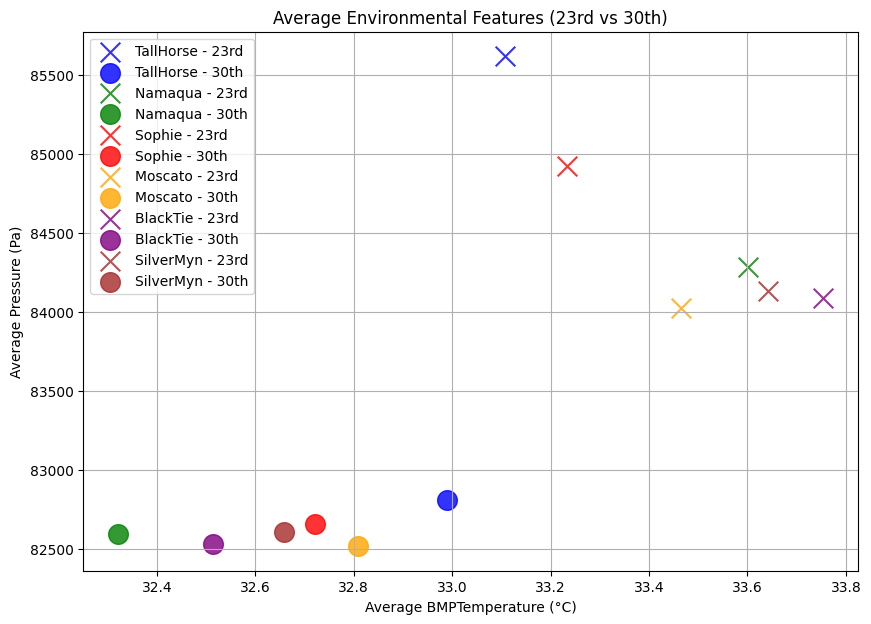

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Separate the environmental features and target labels
env_features = ["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]
env_data = filtered_data_clean[env_features]
target_labels = filtered_data_clean['Target']
day_labels = filtered_data_clean['Day']

# Define the color map for each wine
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Calculate average environmental features for each wine on the 23rd and 30th
average_env_23rd = filtered_data_clean[filtered_data_clean['Day'] == '23rd'].groupby('Target')[env_features].mean()
average_env_30th = filtered_data_clean[filtered_data_clean['Day'] == '30th'].groupby('Target')[env_features].mean()

# Create a new figure for the plot
plt.figure(figsize=(10, 7))
marker_size = 200

# Loop through each wine and plot the average environmental feature differences between the 23rd and 30th
for wine in wine_labels:
    if wine in average_env_23rd.index and wine in average_env_30th.index:
        # Extract the average environmental features for the 23rd and 30th
        avg_env_23rd = average_env_23rd.loc[wine]
        avg_env_30th = average_env_30th.loc[wine]
        
        # Plot 'X' for the 23rd
        plt.scatter(avg_env_23rd['BMPTemperature'], avg_env_23rd['Pressure(Pa)'], 
                    color=color_map[wine], marker='x', label=f'{wine} - 23rd', 
                    s=marker_size, alpha=0.8)
        
        # Plot 'O' for the 30th
        plt.scatter(avg_env_30th['BMPTemperature'], avg_env_30th['Pressure(Pa)'], 
                    color=color_map[wine], marker='o', label=f'{wine} - 30th', 
                    s=marker_size, alpha=0.8)

# Add labels, title, and legend
plt.xlabel('Average BMPTemperature (°C)')
plt.ylabel('Average Pressure (Pa)')
plt.title('Average Environmental Features (23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()


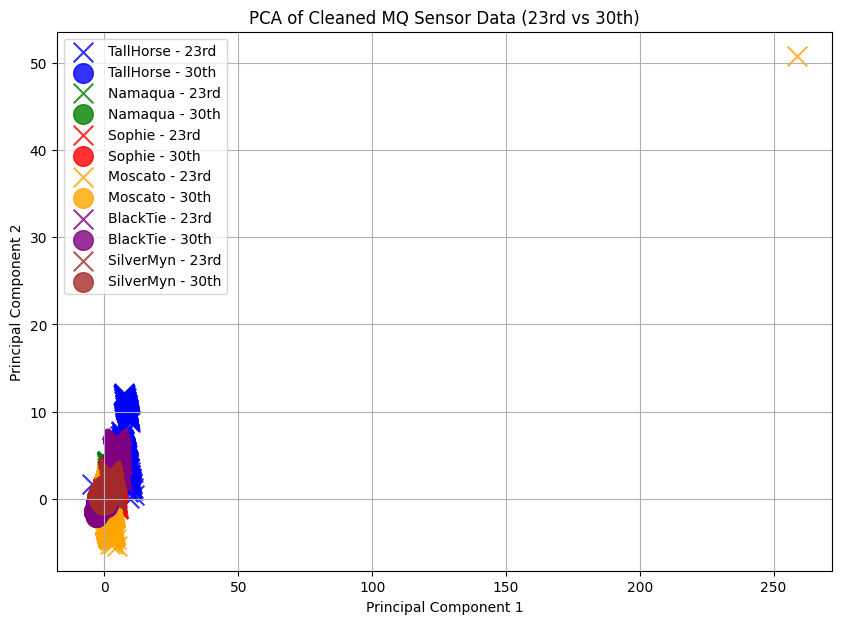

Average Euclidean Distance between the 23rd and 30th for each wine:
TallHorse: 10.3992
Namaqua: 2.9467
Sophie: 3.5010
Moscato: 5.4450
BlackTie: 6.7377
SilverMyn: 3.4036


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import euclidean_distances

# Separate MQ sensor and environmental features
mq_sensors = ["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]
env_features = ["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]

# Initialize a dictionary to store the "cleaned" MQ sensor data
cleaned_mq_data = pd.DataFrame()

# Iterate over each MQ sensor and fit a linear regression model using environmental features as predictors
for sensor in mq_sensors:
    # Define the independent variables (env features) and the dependent variable (MQ sensor)
    X = combined_data_clean[env_features]
    y = combined_data_clean[sensor]
    
    # Fit a linear regression model
    reg = LinearRegression()
    reg.fit(X, y)
    
    # Predict the MQ sensor values based on environmental features
    y_pred = reg.predict(X)
    
    # Subtract the predicted values from the actual MQ sensor values to get the residuals
    # These residuals are the "cleaned" sensor readings with environmental effects removed
    residuals = y - y_pred
    
    # Store the residuals in the cleaned data
    cleaned_mq_data[sensor] = residuals

# Add back the target labels and day labels to the cleaned MQ sensor data
cleaned_mq_data['Target'] = combined_data_clean['Target'].values
cleaned_mq_data['Day'] = combined_data_clean['Day'].values

# Now, perform PCA on the cleaned MQ sensor data
pca = PCA(n_components=2)
scaled_data = StandardScaler().fit_transform(cleaned_mq_data[mq_sensors])  # Scaling the data
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Target'] = cleaned_mq_data['Target']
pca_df['Day'] = cleaned_mq_data['Day']

plt.figure(figsize=(10, 7))
marker_size = 200

# Define color map for each wine label
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Store Euclidean distances for each wine
wine_distances = {}

# Loop through each wine and plot the cleaned data for the 23rd and 30th
for wine in wine_labels:
    # Get PCA data for the 23rd and 30th for the current wine
    wine_data_23rd = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '23rd')]
    wine_data_30th = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '30th')]
    
    # Plot 'X' for the 23rd
    plt.scatter(wine_data_23rd['PC1'], wine_data_23rd['PC2'], 
                color=color_map[wine], marker='x', label=f'{wine} - 23rd', 
                s=marker_size, alpha=0.8)
    
    # Plot 'O' for the 30th
    plt.scatter(wine_data_30th['PC1'], wine_data_30th['PC2'], 
                color=color_map[wine], marker='o', label=f'{wine} - 30th', 
                s=marker_size, alpha=0.8)
    
    # Calculate Euclidean distance between the 23rd and 30th points
    if len(wine_data_23rd) > 0 and len(wine_data_30th) > 0:
        # Compute pairwise Euclidean distances
        distances = euclidean_distances(wine_data_23rd[['PC1', 'PC2']].values,
                                        wine_data_30th[['PC1', 'PC2']].values)
        
        # Calculate average Euclidean distance for the wine
        avg_distance = np.mean(distances)
        wine_distances[wine] = avg_distance

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Cleaned MQ Sensor Data (23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()

# Print Euclidean distances between the 23rd and 30th for each wine
print("Average Euclidean Distance between the 23rd and 30th for each wine:")
for wine, distance in wine_distances.items():
    print(f"{wine}: {distance:.4f}")

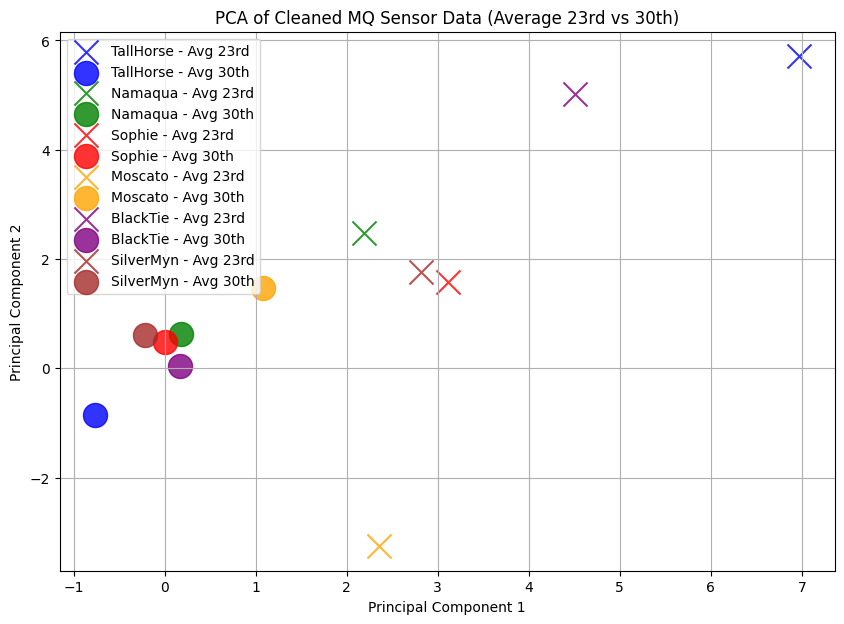

In [19]:
# Create a new plot to show the average X and O for each wine
plt.figure(figsize=(10, 7))
marker_size = 300  # Larger marker size for the averages

# Loop through each wine and calculate the average PC1 and PC2 for the 23rd and 30th
for wine in wine_labels:
    # Get PCA data for the 23rd and 30th for the current wine
    wine_data_23rd = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '23rd')]
    wine_data_30th = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '30th')]
    
    # Calculate the average PC1 and PC2 for the 23rd
    avg_23rd = wine_data_23rd[['PC1', 'PC2']].mean()
    
    # Calculate the average PC1 and PC2 for the 30th
    avg_30th = wine_data_30th[['PC1', 'PC2']].mean()
    
    # Plot the average point for the 23rd (X)
    plt.scatter(avg_23rd['PC1'], avg_23rd['PC2'], 
                color=color_map[wine], marker='x', label=f'{wine} - Avg 23rd', 
                s=marker_size, alpha=0.8)
    
    # Plot the average point for the 30th (O)
    plt.scatter(avg_30th['PC1'], avg_30th['PC2'], 
                color=color_map[wine], marker='o', label=f'{wine} - Avg 30th', 
                s=marker_size, alpha=0.8)

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Cleaned MQ Sensor Data (Average 23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()


In [32]:
# from sklearn.preprocessing import StandardScaler

# # Standardize the features (mean=0, variance=1)
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features)

# # Create a new DataFrame with scaled features for further analysis
# scaled_data = pd.DataFrame(scaled_features, columns=features.columns)
# scaled_data['Target'] = target_labels
# scaled_data['Day'] = day_labels

# scaled_data.head()  # Check the scaled data


,MQ6,MQ5,MQ4,MQ7,MQ3,MQ8,MQ2,MQ135,MQ9,BMPTemperature,Pressure(Pa),DHTTemperature,Humidity,Target,Day
0,0.340147,0.326440,0.510462,0.937327,-4.433567,0.839629,5.678840,3.875448,1.045740,3.320620,1.199601,-1.219483,0.349004,BlackTie,23rd
1,0.330054,0.369619,0.510462,0.937327,-4.263904,0.839629,5.678840,3.847206,1.129828,3.359788,1.014497,-1.219483,0.349004,BlackTie,23rd
2,0.330054,0.412799,0.478683,0.885918,-4.603231,0.839629,5.678840,3.847206,1.045740,3.398956,0.913853,-1.219483,0.349004,BlackTie,23rd
3,0.309867,0.369619,0.542240,0.963032,-4.433567,0.839629,5.810965,3.875448,1.213917,3.398956,0.619745,-1.219483,0.349004,BlackTie,23rd
4,0.330054,0.369619,0.478683,0.885918,-4.433567,0.839629,5.678840,3.847206,1.045740,3.398956,0.553127,-1.219483,0.349004,BlackTie,23rd


In [36]:
# from sklearn.linear_model import LinearRegression

# # Separate environmental features and gas sensor data
# env_features = filtered_data[["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]]
# gas_sensors = filtered_data[["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]]

# # Fit a linear regression model to predict sensor values based on environmental factors
# reg_model = LinearRegression()
# reg_model.fit(env_features, gas_sensors)

# # Predict the sensor values using environmental features
# predicted_sensors = reg_model.predict(env_features)

# # Subtract predicted values from actual sensor readings to remove environmental influence
# residual_sensors = gas_sensors - predicted_sensors

# # Create a new DataFrame with residuals and target labels
# residual_data = pd.DataFrame(residual_sensors, columns=gas_sensors.columns)
# residual_data['Target'] = target_labels
# residual_data['Day'] = day_labels

# residual_data.head()  # Check the residual data


,MQ6,MQ5,MQ4,MQ7,MQ3,MQ8,MQ2,MQ135,MQ9,Target,Day
0,108.176663,7.493150,15.880180,16.129944,-12.760260,75.661820,61.798441,59.644881,-4.697129,BlackTie,23rd
1,101.202238,7.884492,14.992106,15.259455,-11.611910,73.898103,61.426829,60.993506,-2.923671,BlackTie,23rd
2,98.016661,8.499462,13.436380,12.572896,-13.471425,73.038239,61.106948,61.958040,-3.567101,BlackTie,23rd
3,86.305174,6.720730,14.279059,14.932410,-12.444038,69.890790,62.926806,67.777802,-0.115391,BlackTie,23rd
4,86.105452,6.544342,12.016917,11.787335,-12.437834,69.177871,60.886002,67.869513,-1.786568,BlackTie,23rd


In [27]:
# import torch
# import torch.nn as nn

# # Define the autoencoder model
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(13, 8),
#             nn.ReLU(),
#             nn.Linear(8, 3)  # Reduce to 3-dimensional latent space
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(3, 8),
#             nn.ReLU(),
#             nn.Linear(8, 13)  # Reconstruct original feature set
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# # Initialize the model, loss function, and optimizer
# model = Autoencoder()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Prepare data for training (convert to torch tensors)
# features_tensor = torch.tensor(scaled_features, dtype=torch.float32)

# # Training loop
# for epoch in range(100):  # Example number of epochs
#     optimizer.zero_grad()
#     outputs = model(features_tensor)
#     loss = criterion(outputs, features_tensor)
#     loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss: {loss.item()}')

# # After training, extract the encoded features
# with torch.no_grad():
#     encoded_features = model.encoder(features_tensor).numpy()

# # Create a DataFrame with the encoded features
# encoded_data = pd.DataFrame(encoded_features, columns=['Latent1', 'Latent2', 'Latent3'])
# encoded_data['Target'] = target_labels
# encoded_data['Day'] = day_labels

# encoded_data.head()  # Check the encoded features


Epoch 0, Loss: 1.0495800971984863
Epoch 10, Loss: 1.0272074937820435
Epoch 20, Loss: 1.0093036890029907
Epoch 30, Loss: 0.9928930401802063
Epoch 40, Loss: 0.9747068285942078
Epoch 50, Loss: 0.953523576259613
Epoch 60, Loss: 0.9279383420944214
Epoch 70, Loss: 0.8975426554679871
Epoch 80, Loss: 0.8632144331932068
Epoch 90, Loss: 0.8271591663360596


,Latent1,Latent2,Latent3,Target,Day
0,0.123720,0.500623,-2.981549,BlackTie,23rd
1,0.135877,0.501115,-2.986837,BlackTie,23rd
2,0.090012,0.467404,-2.982333,BlackTie,23rd
3,0.107877,0.469976,-3.010742,BlackTie,23rd
4,0.064717,0.430512,-2.942872,BlackTie,23rd


In [34]:
# from sklearn.cluster import KMeans

# # Perform K-means clustering on the scaled features
# kmeans = KMeans(n_clusters=len(wine_labels), random_state=42)
# kmeans.fit(scaled_features)

# # Add the cluster labels to the DataFrame
# scaled_data['Cluster'] = kmeans.labels_

# # Visualize the clustering results
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='MQ6', y='MQ7', hue='Cluster', style='Day', data=scaled_data, palette='Set1')
# plt.title('K-Means Clustering of Wine Data')
# plt.show()


ValueError: Could not interpret value `Cluster` for `hue`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

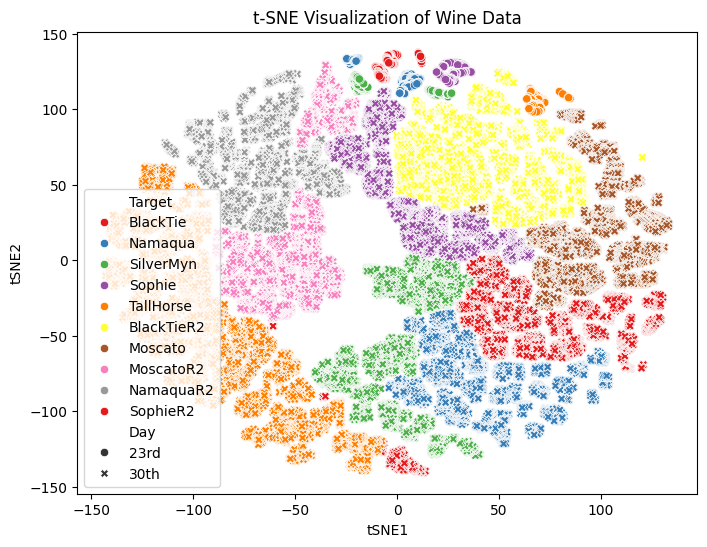

In [29]:
# from sklearn.manifold import TSNE

# # Perform t-SNE on the scaled features
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(scaled_features)

# # Create a DataFrame for the t-SNE results
# tsne_df = pd.DataFrame(tsne_result, columns=['tSNE1', 'tSNE2'])
# tsne_df['Target'] = target_labels
# tsne_df['Day'] = day_labels

# # Plot the t-SNE result
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='tSNE1', y='tSNE2', hue='Target', style='Day', data=tsne_df, palette='Set1')
# plt.title('t-SNE Visualization of Wine Data')
# plt.show()


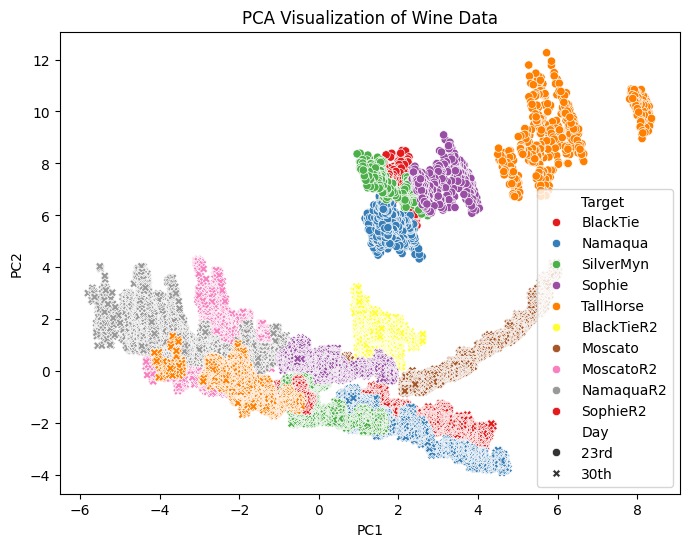

In [30]:
# from sklearn.decomposition import PCA

# # Perform PCA on scaled features
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(scaled_features)

# # Create a DataFrame for PCA results
# pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
# pca_df['Target'] = target_labels
# pca_df['Day'] = day_labels

# # Plot the PCA result
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='PC1', y='PC2', hue='Target', style='Day', data=pca_df, palette='Set1')
# plt.title('PCA Visualization of Wine Data')
# plt.show()


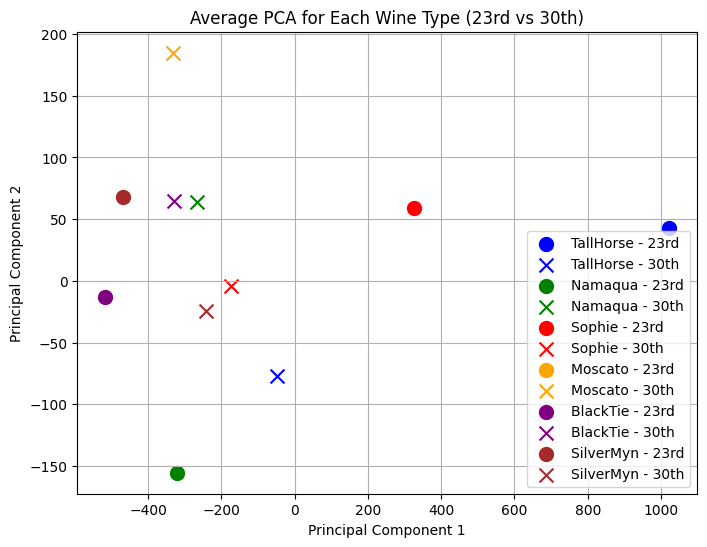

In [35]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Define wine labels
# wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]

# # Define color map for the wines
# color_map = {
#     "TallHorse": 'blue',
#     "Namaqua": 'green',
#     "Sophie": 'red',
#     "Moscato": 'orange',
#     "BlackTie": 'purple',
#     "SilverMyn": 'brown'
# }

# # Define marker styles for different days
# marker_map = {
#     '23rd': 'o',  # Circle for 23rd
#     '30th': 'x'   # X for 30th
# }

# # Function to process each dataset, perform PCA, and calculate average PCA values
# def process_data_for_pca(data, day_label):
#     # Filter for specific wine names in the Target column
#     filtered_data = data[data['Target'].str.contains('|'.join(wine_labels))]

#     # Separate features (MQ and environmental data) from the Target and Day columns
#     features = filtered_data.drop(columns=['Target', 'Day'])
#     target_labels = filtered_data['Target']

#     # Perform PCA with 2 components
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(features)

#     # Create a DataFrame for PCA results
#     pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
#     pca_df['Target'] = target_labels
#     pca_df['Day'] = day_label  # Add the day label

#     # Ensure the PCA components are numeric before applying mean
#     pca_df[['PC1', 'PC2']] = pca_df[['PC1', 'PC2']].apply(pd.to_numeric)

#     # Group by wine type and calculate the average of the PCA components
#     mean_pca = pca_df.groupby('Target', as_index=False)[['PC1', 'PC2']].mean()
    
#     return mean_pca

# # Perform PCA on both datasets
# mean_pca_23rd = process_data_for_pca(data_23rd, '23rd')
# mean_pca_30th = process_data_for_pca(data_30th, '30th')

# # Combine both datasets for plotting
# combined_mean_pca = pd.concat([mean_pca_23rd, mean_pca_30th])

# # Plotting the average PCA values for each wine type from both datasets
# plt.figure(figsize=(8, 6))

# # Scatter plot for both days with different markers but same colors for the same wine
# for wine in wine_labels:
#     # Plot data for 23rd
#     avg_pca_values_23rd = mean_pca_23rd[mean_pca_23rd['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
#         label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
#     )

#     # Plot data for 30th
#     avg_pca_values_30th = mean_pca_30th[mean_pca_30th['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
#         label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
#     )

# # Add labels and title
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Average PCA for Each Wine Type (23rd vs 30th)')
# plt.legend(loc='best')
# plt.grid(True)

# # Show the plot
# plt.show()


In [38]:
# # Function to fit a linear regression model and obtain residuals
# def calculate_residuals(data):
#     # Filter for specific wine names in the Target column
#     filtered_data = data[data['Target'].str.contains('|'.join(wine_labels))]

#     # Separate environmental features and gas sensor data
#     env_features = filtered_data[["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]]
#     gas_sensors = filtered_data[["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]]

#     # Fit a linear regression model to predict sensor values based on environmental factors
#     reg_model = LinearRegression()
#     reg_model.fit(env_features, gas_sensors)

#     # Predict the sensor values using environmental features
#     predicted_sensors = reg_model.predict(env_features)

#     # Subtract predicted values from actual sensor readings to remove environmental influence
#     residual_sensors = gas_sensors - predicted_sensors

#     # Create a new DataFrame with residuals and target labels
#     residual_data = pd.DataFrame(residual_sensors, columns=gas_sensors.columns)
#     residual_data['Target'] = filtered_data['Target'].values
#     residual_data['Day'] = filtered_data['Day'].values
    
#     return residual_data

# # Calculate residuals for both datasets
# residual_data_23rd = calculate_residuals(data_23rd)
# residual_data_30th = calculate_residuals(data_30th)


In [39]:

# # Function to process residual data, perform PCA, and calculate average PCA values
# def process_data_for_pca(residual_data, day_label):
#     # Separate features from the Target and Day columns
#     features = residual_data.drop(columns=['Target', 'Day'])
#     target_labels = residual_data['Target']

#     # Perform PCA with 2 components
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(features)

#     # Create a DataFrame for PCA results
#     pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
#     pca_df['Target'] = target_labels
#     pca_df['Day'] = day_label  # Add the day label

#     # Group by wine type and calculate the average of the PCA components
#     mean_pca = pca_df.groupby('Target', as_index=False)[['PC1', 'PC2']].mean()
    
#     return mean_pca

# # Perform PCA on both datasets
# mean_pca_23rd = process_data_for_pca(residual_data_23rd, '23rd')
# mean_pca_30th = process_data_for_pca(residual_data_30th, '30th')


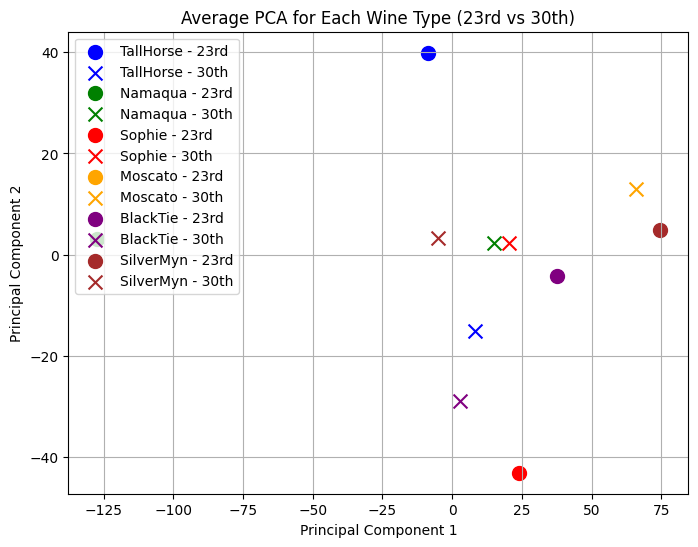

In [40]:
# # Define color map for the wines
# color_map = {
#     "TallHorse": 'blue',
#     "Namaqua": 'green',
#     "Sophie": 'red',
#     "Moscato": 'orange',
#     "BlackTie": 'purple',
#     "SilverMyn": 'brown'
# }

# # Define marker styles for different days
# marker_map = {
#     '23rd': 'o',  # Circle for 23rd
#     '30th': 'x'   # X for 30th
# }

# # Combine both datasets for plotting
# combined_mean_pca = pd.concat([mean_pca_23rd, mean_pca_30th])

# # Plotting the average PCA values for each wine type from both datasets
# plt.figure(figsize=(8, 6))

# # Scatter plot for both days with different markers but same colors for the same wine
# for wine in wine_labels:
#     # Plot data for 23rd
#     avg_pca_values_23rd = mean_pca_23rd[mean_pca_23rd['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
#         label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
#     )

#     # Plot data for 30th
#     avg_pca_values_30th = mean_pca_30th[mean_pca_30th['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
#         label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
#     )

# # Add labels and title
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Average PCA for Each Wine Type (23rd vs 30th)')
# plt.legend(loc='best')
# plt.grid(True)

# # Show the plot
# plt.show()


In [46]:
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Define features (environmental) and target (MQ sensor residuals)
# X = combined_data[["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]].values
# y = combined_data[["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]].values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Convert to PyTorch tensors
# X_train_tensor = torch.FloatTensor(X_train)
# y_train_tensor = torch.FloatTensor(y_train)
# X_test_tensor = torch.FloatTensor(X_test)
# y_test_tensor = torch.FloatTensor(y_test)

# # Define the neural network architecture
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(4, 64)  # Input layer
#         self.fc2 = nn.Linear(64, 64)  # Hidden layer
#         self.fc3 = nn.Linear(64, 9)   # Output layer (MQ sensor outputs)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))  # Activation function
#         x = torch.relu(self.fc2(x))  # Activation function
#         x = self.fc3(x)               # Output layer
#         return x

# # Instantiate the model, define the loss function and the optimizer
# model = NeuralNetwork()
# criterion = nn.MSELoss()  # Mean Squared Error Loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training the model
# num_epochs = 100
# for epoch in range(num_epochs):
#     model.train()
    
#     # Forward pass
#     outputs = model(X_train_tensor)
#     loss = criterion(outputs, y_train_tensor)
    
#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Evaluating the model
# model.eval()
# with torch.no_grad():
#     predicted_sensors = model(X_test_tensor)

# # Calculate residuals
# residuals = predicted_sensors.numpy() - y_test_tensor.numpy()

# # Calculate distances between predicted and actual
# distances = np.linalg.norm(residuals, axis=1)

# # Calculate maximum distances for normalization
# max_distances = np.linalg.norm(y_test_tensor.numpy(), axis=1)

# # Calculate total distance over max distance for all wines
# total_distance = np.sum(distances)
# total_max_distance = np.sum(max_distances)

# error_ratio = total_distance / total_max_distance if total_max_distance > 0 else 0

# print(f'Total Distance: {total_distance:.4f}')
# print(f'Total Max Distance: {total_max_distance:.4f}')
# print(f'Error Ratio (Total Distance / Total Max Distance): {error_ratio:.4f}')


Epoch [10/100], Loss: 454494.4062
Epoch [20/100], Loss: 454099.1875
Epoch [30/100], Loss: 453693.5625
Epoch [40/100], Loss: 453253.1250
Epoch [50/100], Loss: 452772.5312
Epoch [60/100], Loss: 452247.2812
Epoch [70/100], Loss: 451679.7188
Epoch [80/100], Loss: 451070.5938
Epoch [90/100], Loss: 450420.0625
Epoch [100/100], Loss: 449725.6562
Total Distance: 52939380.0000
Total Max Distance: 53224828.0000
Error Ratio (Total Distance / Total Max Distance): 0.9946


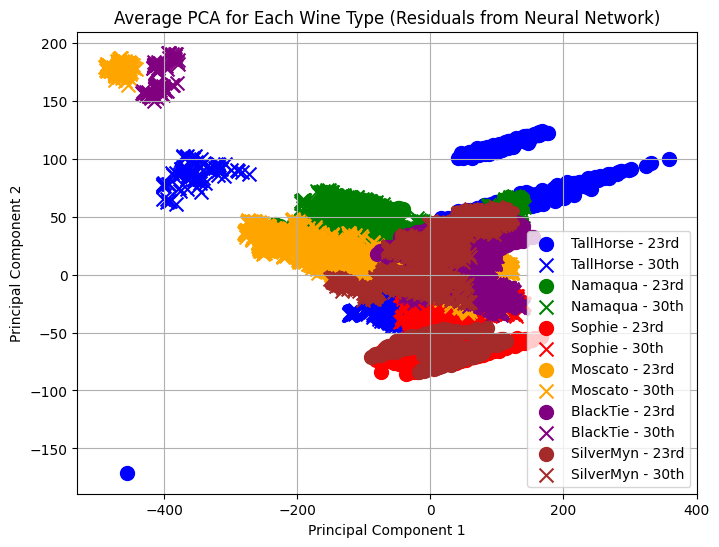

In [44]:
# # Assuming you have the following imports and previous steps:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Define wine labels and color map as before
# wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]
# color_map = {
#     "TallHorse": 'blue',
#     "Namaqua": 'green',
#     "Sophie": 'red',
#     "Moscato": 'orange',
#     "BlackTie": 'purple',
#     "SilverMyn": 'brown'
# }

# # Define marker styles for different days
# marker_map = {
#     '23rd': 'o',  # Circle for 23rd
#     '30th': 'x'   # X for 30th
# }

# # Function to perform PCA on residual data
# def perform_pca_on_residuals(data, day_label):
#     # Filter for specific wine names in the Target column
#     filtered_data = data[data['Target'].str.contains('|'.join(wine_labels))]
    
#     # Separate features (residuals) from the Target and Day columns
#     features = filtered_data.drop(columns=['Target', 'Day'])
#     target_labels = filtered_data['Target']

#     # Perform PCA with 2 components
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(features)

#     # Create a DataFrame for PCA results
#     pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
#     pca_df['Target'] = target_labels
#     pca_df['Day'] = day_label  # Add the day label

#     return pca_df

# # Perform PCA on the residuals for both datasets
# pca_residuals_23rd = perform_pca_on_residuals(residual_data[residual_data['Day'] == '23rd'], '23rd')
# pca_residuals_30th = perform_pca_on_residuals(residual_data[residual_data['Day'] == '30th'], '30th')

# # Combine both datasets for plotting
# combined_pca_residuals = pd.concat([pca_residuals_23rd, pca_residuals_30th])

# # Plotting the average PCA values for each wine type from both datasets
# plt.figure(figsize=(8, 6))

# # Scatter plot for both days with different markers but same colors for the same wine
# for wine in wine_labels:
#     # Plot data for 23rd
#     avg_pca_values_23rd = pca_residuals_23rd[pca_residuals_23rd['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
#         label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
#     )

#     # Plot data for 30th
#     avg_pca_values_30th = pca_residuals_30th[pca_residuals_30th['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
#         label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
#     )

# # Add labels and title
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Average PCA for Each Wine Type (Residuals from Neural Network)')
# plt.legend(loc='best')
# plt.grid(True)

# # Show the plot
# plt.show()


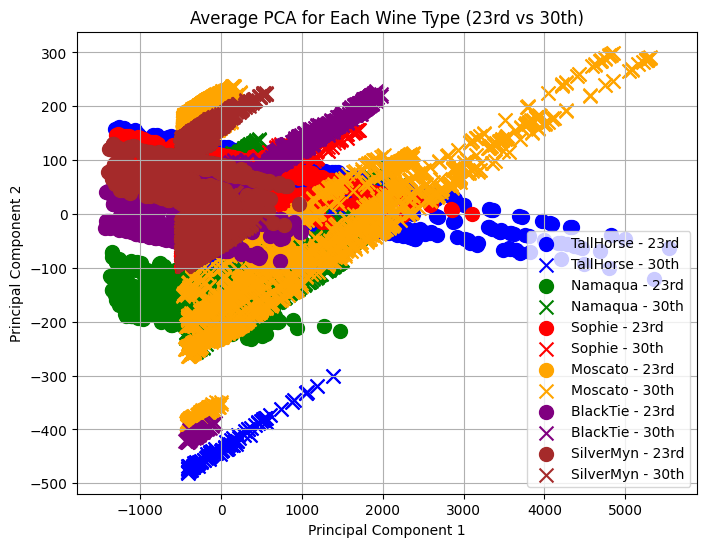

In [45]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Assuming combined_data is your original DataFrame containing the necessary data

# # Define the color map for the wines
# color_map = {
#     "TallHorse": 'blue',
#     "Namaqua": 'green',
#     "Sophie": 'red',
#     "Moscato": 'orange',
#     "BlackTie": 'purple',
#     "SilverMyn": 'brown'
# }

# # Define marker styles for different days
# marker_map = {
#     '23rd': 'o',  # Circle for 23rd
#     '30th': 'x'   # X for 30th
# }

# # Function to perform PCA on given data for a specific day
# def perform_pca(data, day_label):
#     # Filter data for the specific day
#     filtered_data = data[data['Day'] == day_label]
#     features = filtered_data.drop(columns=['Target', 'Day'])
    
#     # Perform PCA
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(features)

#     # Create a DataFrame for PCA results
#     pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
#     pca_df['Target'] = filtered_data['Target']
#     pca_df['Day'] = day_label  # Add the day label

#     return pca_df

# # Perform PCA on the combined data for both datasets
# pca_23rd = perform_pca(combined_data, '23rd')
# pca_30th = perform_pca(combined_data, '30th')

# # Combine both datasets for plotting
# combined_mean_pca = pd.concat([pca_23rd, pca_30th])

# # Define wine labels for plotting
# wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]

# # Plotting the average PCA values for each wine type from both datasets
# plt.figure(figsize=(8, 6))

# # Scatter plot for both days with different markers but same colors for the same wine
# for wine in wine_labels:
#     # Plot data for 23rd
#     avg_pca_values_23rd = pca_23rd[pca_23rd['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
#         label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
#     )

#     # Plot data for 30th
#     avg_pca_values_30th = pca_30th[pca_30th['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
#         label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
#     )

# # Add labels and title
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Average PCA for Each Wine Type (23rd vs 30th)')
# plt.legend(loc='best')
# plt.grid(True)

# # Show the plot
# plt.show()
